In [1]:
# Get the data for expeirment
import pandas as pd 
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
import seaborn as sns
import TsModel
import GprModel
import TsModel_constant
import torch
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers, models

device = torch.device("cuda:0")
print(f"Keras version is {keras.__version__}")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
plt.rcParams.update({'font.size': 20})

Keras version is 3.1.1
Num GPUs Available: 1


In [22]:
exp23_results = {
    'nn_train_accuracy' : nn_train_accuracy,
    'nn_test_accuracy':nn_test_accuracy,
    'nn_r2s':nn_r2s,
    'nn_time':nn_time,
    'gp_train_accuracy':gp_train_accuracy,
    'gp_test_accuracy':gp_test_accuracy,
    'gp_r2s':gp_r2s,
    'gp_time':gp_time,
    'tsl_train_accuracy' : tsl_train_accuracy,
    'tsl_test_accuracy' :tsl_test_accuracy,
    'tsl_r2s':tsl_r2s,
    'tsl_time': tsl_time,
    'tsc_train_accuracy':tsc_train_accuracy,
    'tsc_test_accuracy':tsc_test_accuracy,
    'tsc_r2s':tsc_r2s,
    'tsc_time':tsc_time
}

In [23]:
#%store exp23_results 

Stored 'exp23_results' (dict)


In [2]:
# Train and test the solar data set
x_train = pd.read_csv('Data/FES/small_wind_turbine_x_train.csv')
x_test = pd.read_csv('Data/FES/small_wind_turbine_x_test.csv')
y_train = pd.read_csv('Data/FES/small_wind_turbine_y_train.csv')
y_test = pd.read_csv('Data/FES/small_wind_turbine_y_test.csv')

In [3]:
number_of_folds = 10

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    # target_scaler = StandardScaler()  
    # scaled_train_y = target_scaler.fit_transform(train_y)
    # scaled_test_y = target_scaler.transform(test_y)    
    # scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

    return scaled_train_x, scaled_test_x, feature_scaler    

def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(9, activation=keras.activations.tanh))    
    model.add(layers.Dense(18, activation=keras.activations.tanh))    
    model.add(layers.Dense(1, activation=keras.activations.relu))
    return model

In [4]:
x_train, x_test, feature_scaler = preprocess_data(x_train, x_test, y_train, y_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [7]:
nn_train_accuracy = []
nn_test_accuracy = []
nn_r2s = []
nn_time = []
histories = []

def do_nn_exp():
    for fold in range(number_of_folds):
        neural_network_model = build_neural_network_model()

        neural_network_model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.RootMeanSquaredError()]
        )

        start_time = time.time()
        history = neural_network_model.fit(
            x_train, 
            y_train,
            epochs=100, 
            shuffle=True
        )
        time_used = time.time() - start_time

        _, train_rmse = neural_network_model.evaluate(x_train, y_train)
        nn_train_accuracy.append(train_rmse)
        _, test_rmse = neural_network_model.evaluate(x_test, y_test)
        nn_test_accuracy.append(test_rmse)
        nn_r2 = r2_score(y_test, neural_network_model.predict(x_test))
        nn_r2s.append(nn_r2)
        nn_time.append(time_used)
        histories.append(history)
    
    return neural_network_model

In [8]:
nn_model = do_nn_exp()

Epoch 1/100
4901/4901 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 15122.3203 - root_mean_squared_error: 122.8832
Epoch 2/100
4901/4901 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 10440.6787 - root_mean_squared_error: 102.0184
Epoch 3/100
4901/4901 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 7469.6758 - root_mean_squared_error: 86.3544
Epoch 4/100
4901/4901 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 5925.4214 - root_mean_squared_error: 76.8775
Epoch 5/100
4901/4901 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 4585.4014 - root_mean_squared_error: 67.6284
Epoch 6/100
4901/4901 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 3515.6399 - root_mean_squared_error: 59.2640
Epoch 7/100
4901/4901 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 2851.7532 - root_mean_squared_error: 53.3617
Epoch 8/100
4901/4901 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 2323.4548 - root_mean_squared_error: 48.1318
Epoch 9/100
4901/4901 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 2154.5256 - root_mean_squared_error: 46.3683
Epoch 10/100
49

In [9]:
nn_train_accuracy_mean = np.round(np.mean(nn_train_accuracy), 3)
nn_train_accuracy_std = np.round(np.std(nn_train_accuracy), 3)
nn_test_accuracy_mean = np.round(np.mean(nn_test_accuracy), 3)
nn_test_accuracy_std = np.round(np.std(nn_test_accuracy),3)
nn_r2_mean = np.round(np.mean(nn_r2s),3)
nn_r2_std = np.round(np.std(nn_r2s),3)
nn_time_mean = np.round(np.mean(nn_time),3)
nn_time_std = np.round(np.std(nn_time),3)

print(f"NN Train RMSE: {nn_train_accuracy_mean} ± {nn_train_accuracy_std}")
print(f"NN Test RMSE: {nn_test_accuracy_mean} ± {nn_test_accuracy_std}")
print(f"NN R2: {nn_r2_mean} ± {nn_r2_std}")
print(f"NN Time: {nn_time_mean} ± {nn_time_std}")

NN Train RMSE: 11.792 ± 0.183
NN Test RMSE: 12.886 ± 0.257
NN R2: 0.989 ± 0.0
NN Time: 2612.132 ± 876.255


2101/2101 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step


Text(0.5, 1.0, 'NN prediction vs true value for testing data')

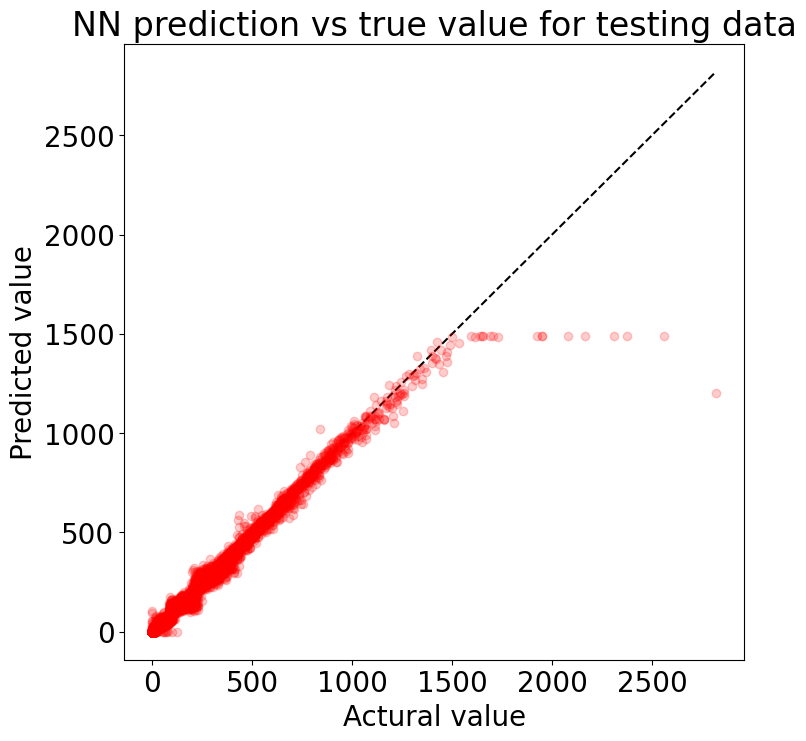

In [10]:
# Visualiza the error

plt.figure(figsize=(8,8))    
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, nn_model.predict(x_test), 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('NN prediction vs true value for testing data')

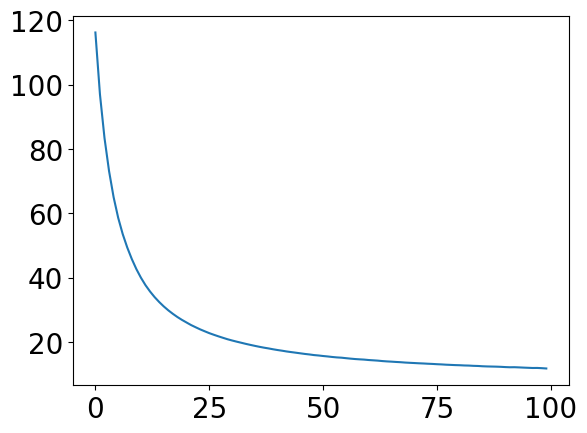

In [11]:
plt.plot(histories[0].history['root_mean_squared_error'], label='Training RMSE')

In [21]:
#nn_model.save('small_wind_turbine_nn.keras')

In [12]:
# GPR model
gp_train_accuracy = []
gp_test_accuracy = []
gp_r2s = []
gp_time = []
gpr_model = None

for fold in range(number_of_folds):
    
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)
    indices = np.random.choice(x_train.shape[0], 2000, replace=False)            

    start_time = time.time()
    gpr_model.fit(x_train[indices,:], y_train[indices,:])
    time_used = time.time() - start_time

    train_means = gpr_model.predict(x_train)
    test_means = gpr_model.predict(x_test)

    train_rmse = root_mean_squared_error(y_train, train_means)
    test_rmse = root_mean_squared_error(y_test, test_means)

    gp_train_accuracy.append(train_rmse)
    gp_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_means)
    gp_r2s.append(gp_r2)
    gp_time.append(time_used)


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [13]:
gp_train_accuracy_mean = np.round(np.mean(gp_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_r2s),3)
gp_r2_std = np.round(np.std(gp_r2s),3)
gp_time_mean = np.round(np.mean(gp_time),3)
gp_time_std = np.round(np.std(gp_time),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")

GP Train RMSE: 16.254 ± 1.252
GP Test RMSE: 16.862 ± 1.512
GP R2: 0.981 ± 0.004
GP Time: 98.1 ± 27.246


In [14]:
# TS model
# Linear conclusion

def ts_relu_wrapper(pred):
    return np.maximum(0, pred)

# TS with linear conclusion
tsl_train_accuracy = []
tsl_test_accuracy = []
tsl_r2s = []
tsl_time = []
tsl_model = None

for fold in range(number_of_folds):
    ts_model = TsModel.TsModel(number_of_rules=25, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsl_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsl_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsl_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsl_test_pred)

    tsl_train_accuracy.append(train_rmse)
    tsl_test_accuracy.append(test_rmse)
    tsl_r2 = r2_score(y_test, tsl_test_pred)
    tsl_r2s.append(tsl_r2)
    tsl_time.append(time_used)
    tsl_model = ts_model


FCM training RMSE: 16.134079326628292
FCM training RMSE: 15.499029536135144
FCM training RMSE: 14.832981981001488
FCM training RMSE: 16.133946505999816
FCM training RMSE: 15.84040644873478
FCM training RMSE: 16.60123165825658
FCM training RMSE: 16.00819087638642
FCM training RMSE: 15.973378735925964
FCM training RMSE: 15.917552342534261
FCM training RMSE: 16.026763117514825


In [15]:
tsl_train_accuracy_mean = np.round(np.mean(tsl_train_accuracy), 3)
tsl_train_accuracy_std = np.round(np.std(tsl_train_accuracy), 3)
tsl_test_accuracy_mean = np.round(np.mean(tsl_test_accuracy), 3)
tsl_test_accuracy_std = np.round(np.std(tsl_test_accuracy),3)
tsl_r2_mean = np.round(np.mean(tsl_r2s),3)
tsl_r2_std = np.round(np.std(tsl_r2s),3)
tsl_time_mean = np.round(np.mean(tsl_time),3)
tsl_time_std = np.round(np.std(tsl_time),3)

print(f"TS Linear Train RMSE: {tsl_train_accuracy_mean} ± {tsl_train_accuracy_std}")
print(f"TS Linear Test RMSE: {tsl_test_accuracy_mean} ± {tsl_test_accuracy_std}")
print(f"TS Linear R2: {tsl_r2_mean} ± {tsl_r2_std}")
print(f"TS Linear Time: {tsl_time_mean} ± {tsl_time_std}")

TS Linear Train RMSE: 15.122 ± 0.403
TS Linear Test RMSE: 16.592 ± 0.787
TS Linear R2: 0.982 ± 0.002
TS Linear Time: 47.921 ± 1.297


Text(0.5, 1.0, 'TS prediction vs true value for testing data')

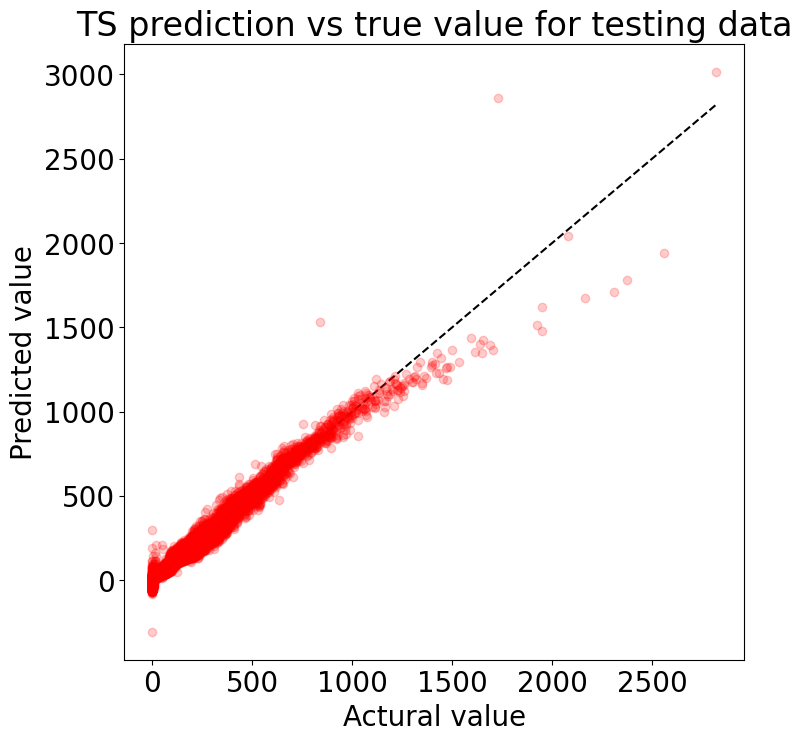

In [16]:
# Visualiza the error
ts_pred = tsl_model.predict(x_test)

plt.figure(figsize=(8,8))    
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, ts_pred, 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('TS prediction vs true value for testing data')

In [17]:
# TS model
# Constant conclusion
tsc_train_accuracy = []
tsc_test_accuracy = []
tsc_r2s = []
tsc_time = []
tsc_model = None

for fold in range(number_of_folds):
    ts_model = TsModel_constant.TsModel_constant(number_of_rules=25, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsc_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsc_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsc_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsc_test_pred)

    tsc_train_accuracy.append(train_rmse)
    tsc_test_accuracy.append(test_rmse)
    tsc_r2 = r2_score(y_test, tsc_test_pred)
    tsc_r2s.append(tsc_r2)
    tsc_time.append(time_used)
    tsc_model = ts_model

(156830, 250)
[[5.81493232e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.81340407e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.55928271e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.07415417e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.49039847e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99998250e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(156830, 25)
[[5.81493232e-06 1.12221157e-01 1.99881112e-02 ... 1.53232469e-03
  8.51056466e-06 7.90757619e-06]
 [4.81340407e-05 1.55667281e-08 8.46015963e-07 ... 1.76256422e-07
  3.48879856e-01 4.45632752e-04]
 [9.55928271e-07 7.41243076e-01 5.54449808e-04 ... 2.04486243e-01
  2.90909716e-06 5.41801443e-06]
 ...
 [2.07415417e-07 8.10450526e-10 2.04308837e-09 ... 3.06965800e-08
  1.1

In [18]:
tsc_train_accuracy_mean = np.round(np.mean(tsc_train_accuracy), 3)
tsc_train_accuracy_std = np.round(np.std(tsc_train_accuracy), 3)
tsc_test_accuracy_mean = np.round(np.mean(tsc_test_accuracy), 3)
tsc_test_accuracy_std = np.round(np.std(tsc_test_accuracy),3)
tsc_r2_mean = np.round(np.mean(tsc_r2s),3)
tsc_r2_std = np.round(np.std(tsc_r2s),3)
tsc_time_mean = np.round(np.mean(tsc_time),3)
tsc_time_std = np.round(np.std(tsc_time),3)

print(f"TS Constant Train RMSE: {tsc_train_accuracy_mean} ± {tsc_train_accuracy_std}")
print(f"TS Constant Test RMSE: {tsc_test_accuracy_mean} ± {tsc_test_accuracy_std}")
print(f"TS Constant R2: {tsc_r2_mean} ± {tsc_r2_std}")
print(f"TS Constant Time: {tsc_time_mean} ± {tsc_time_std}")

TS Constant Train RMSE: 55.903 ± 5.447
TS Constant Test RMSE: 56.659 ± 5.757
TS Constant R2: 0.784 ± 0.043
TS Constant Time: 48.567 ± 0.516


Text(0.5, 1.0, 'TS prediction vs true value for testing data')

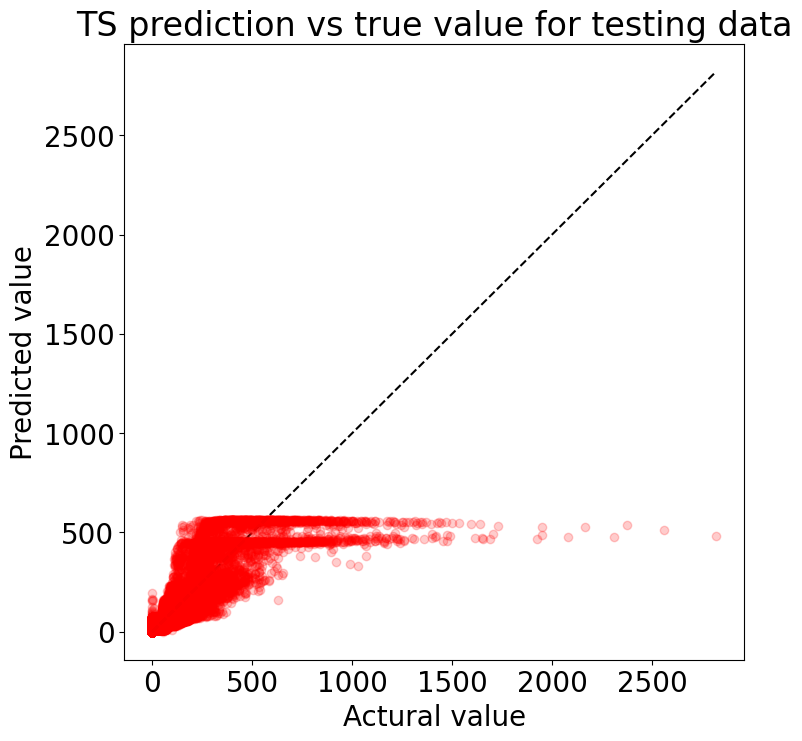

In [19]:
# Visualiza the error
ts_const_pred = ts_relu_wrapper(tsc_model.predict(x_test))

plt.figure(figsize=(8,8))    
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, ts_const_pred, 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('TS prediction vs true value for testing data')